In [1]:
from functions import *
from torchvision.transforms import InterpolationMode


# --- Configuration ---
class Config:
    saved_dir = 'saved'
    data_dir = "./pnev"
    backbone = "resnet18"
    version = 'pneumonia_task4'
    projection_dim = 128
    batch_size = 512
    simclr_epochs = 100
    learning_rate = 0.6
    weight_decay = 1e-6
    temperature = 0.5
    finetune_epochs = 100
    log_interval = 1

args = Config()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import resnet18
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=(224, 224),
        scale=(0.75, 1.0),
        ratio=(0.75, 1.0),
        interpolation=InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.RandomApply(
        [transforms.ColorJitter(
            brightness=(0.9, 1.1),
            contrast=(0.9, 1.1),
            saturation=(0.9, 1.1),
            hue=(-0.1, 0.1)
        )],
        p=0.7
    ),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor(),
])



Using downloaded and verified file: C:\Users\sever\.medmnist\pneumoniamnist_224.npz


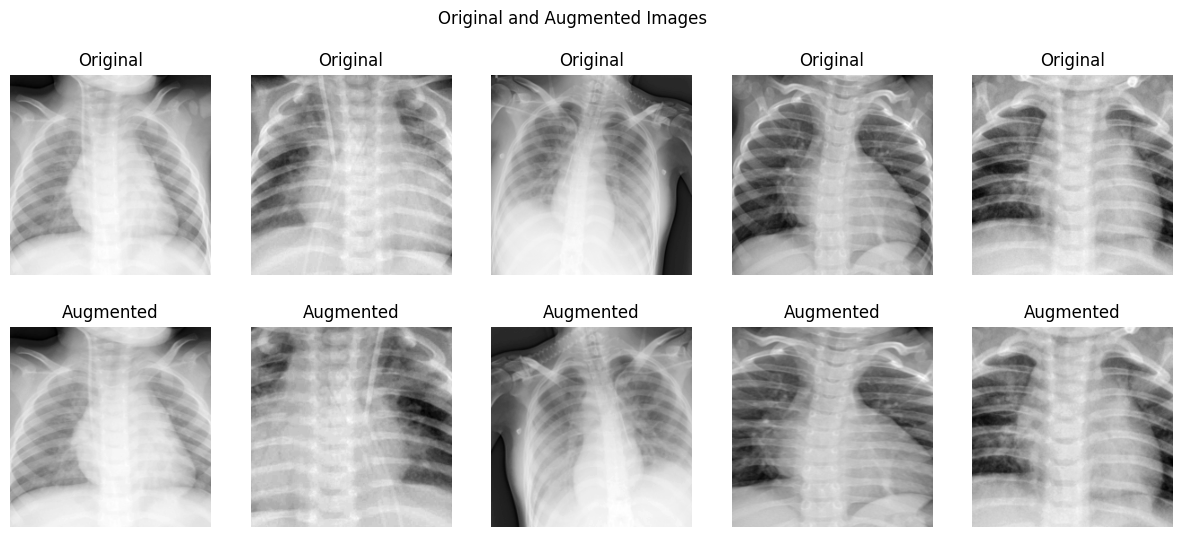

In [2]:
from medmnist import ChestMNIST, PneumoniaMNIST

# pneumoniamnist = GenericPairDataset(split='train', download=True, as_rgb=False, size=224)
pneumoniamnist = PneumoniaMNIST(split='train', download=True, as_rgb=False, size=224)
pneum_pair = GenericPairDataset(pneumoniamnist, transform=train_transform)
train_loader = DataLoader(pneum_pair, batch_size=args.batch_size, shuffle=True)


visualize(train_transform, pneumoniamnist, num_examples=5)


In [3]:
base_encoder = resnet18
model = SimCLR(base_encoder, projection_dim=args.projection_dim).to(device)

optimizer = SGD(model.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=args.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step, args.simclr_epochs * len(train_loader), args.learning_rate, 1e-4))

train_loss_simclr = train_simclr(model, train_loader, optimizer, scheduler, device, args.simclr_epochs)
torch.save(model.state_dict(), f"./{args.saved_dir}/{args.version}.pt")

c:\Users\sever\OneDrive\Рабочий стол\Homework2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\Homework2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 10/10 [00:15<00:00,  1.50s/it]
INFO:functions:Epoch 1, Avg Loss: 6.4670
100%|██████████| 10/10 [00:14<00:00,  1.45s/it]
INFO:functions:Epoch 2, Avg Loss: 6.1855
100%|██████████| 10/10 [00:14<00:00,  1.46s/it]
INFO:functions:Epoch 3, Avg Loss: 6.0418
100%|██████████| 10/10 [00:14<00:00,  1.45s/it]
INFO:functions:Epoch 4, Avg Loss: 5.9127
100%|██████████| 10/10 [00:14<00:00,  1.46s/it]
INFO:functions:Epoch 5, A

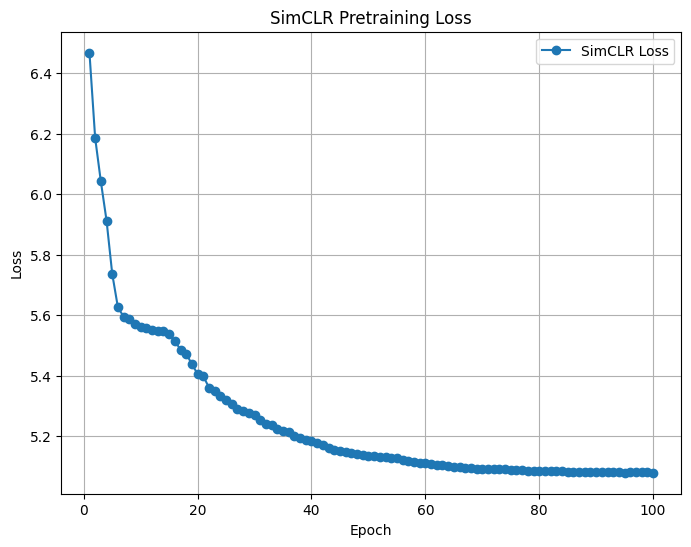

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, args.simclr_epochs + 1), train_loss_simclr, label="SimCLR Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimCLR Pretraining Loss")
plt.legend()
plt.grid(True)

plt.savefig(f'./{args.saved_dir}/pretrain_{args.version}.jpg') 

plt.show()


In [5]:
# Linear Probe
from medmnist import PneumoniaMNIST

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set_single = PneumoniaMNIST(split='train', download=True, as_rgb=False, transform=train_transform)
test_set_single = PneumoniaMNIST(split='test', download=True, as_rgb=False, transform=test_transform)
train_loader_single = DataLoader(train_set_single, batch_size=args.batch_size, shuffle=True)
test_loader_single = DataLoader(test_set_single, batch_size=args.batch_size, shuffle=False)


Using downloaded and verified file: C:\Users\sever\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\sever\.medmnist\pneumoniamnist.npz


In [6]:
for param in model.enc.parameters():
    param.requires_grad = False
    
lin_model = LinModel(model.enc, model.feature_dim, n_classes=2).to(device)

optimizer = torch.optim.SGD(
    lin_model.parameters(),
    lr=0.2, 
    momentum=0.9,
    weight_decay=0.,
    nesterov=True
)

scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(
        step,
        args.finetune_epochs * len(train_loader_single),
        args.learning_rate,
        1e-4
    )
)

# --- Обучение ---
results = train_linear_probe(
    lin_model,
    train_loader_single,
    test_loader_single,
    optimizer,
    scheduler,
    device,
    args.finetune_epochs,
    [0.5, 0.5]
)


train_losses, test_losses, train_f1_scores, test_f1_scores, train_recalls, test_recalls, train_precisions, test_precisions = results

Epoch 1/100 - Testing: 100%|██████████| 2/2 [00:00<00:00, 37.66it/s]
INFO:functions:Epoch 1/100: Train F1=0.8853, Test F1=0.7692, Train Recall=0.8795, Test Recall=1.0000
Epoch 2/100 - Testing: 100%|██████████| 2/2 [00:00<00:00, 44.44it/s]
INFO:functions:Epoch 2/100: Train F1=0.9517, Test F1=0.7692, Train Recall=0.9559, Test Recall=1.0000
Epoch 3/100 - Testing: 100%|██████████| 2/2 [00:00<00:00, 64.28it/s]
INFO:functions:Epoch 3/100: Train F1=0.9519, Test F1=0.7692, Train Recall=0.9522, Test Recall=1.0000
Epoch 4/100 - Testing: 100%|██████████| 2/2 [00:00<00:00, 76.92it/s]
INFO:functions:Epoch 4/100: Train F1=0.9510, Test F1=0.7692, Train Recall=0.9502, Test Recall=1.0000
Epoch 5/100 - Testing: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]
INFO:functions:Epoch 5/100: Train F1=0.9508, Test F1=0.7692, Train Recall=0.9568, Test Recall=1.0000
Epoch 6/100 - Testing: 100%|██████████| 2/2 [00:00<00:00, 57.14it/s]
INFO:functions:Epoch 6/100: Train F1=0.9033, Test F1=0.7692, Train Recall=0.8958,

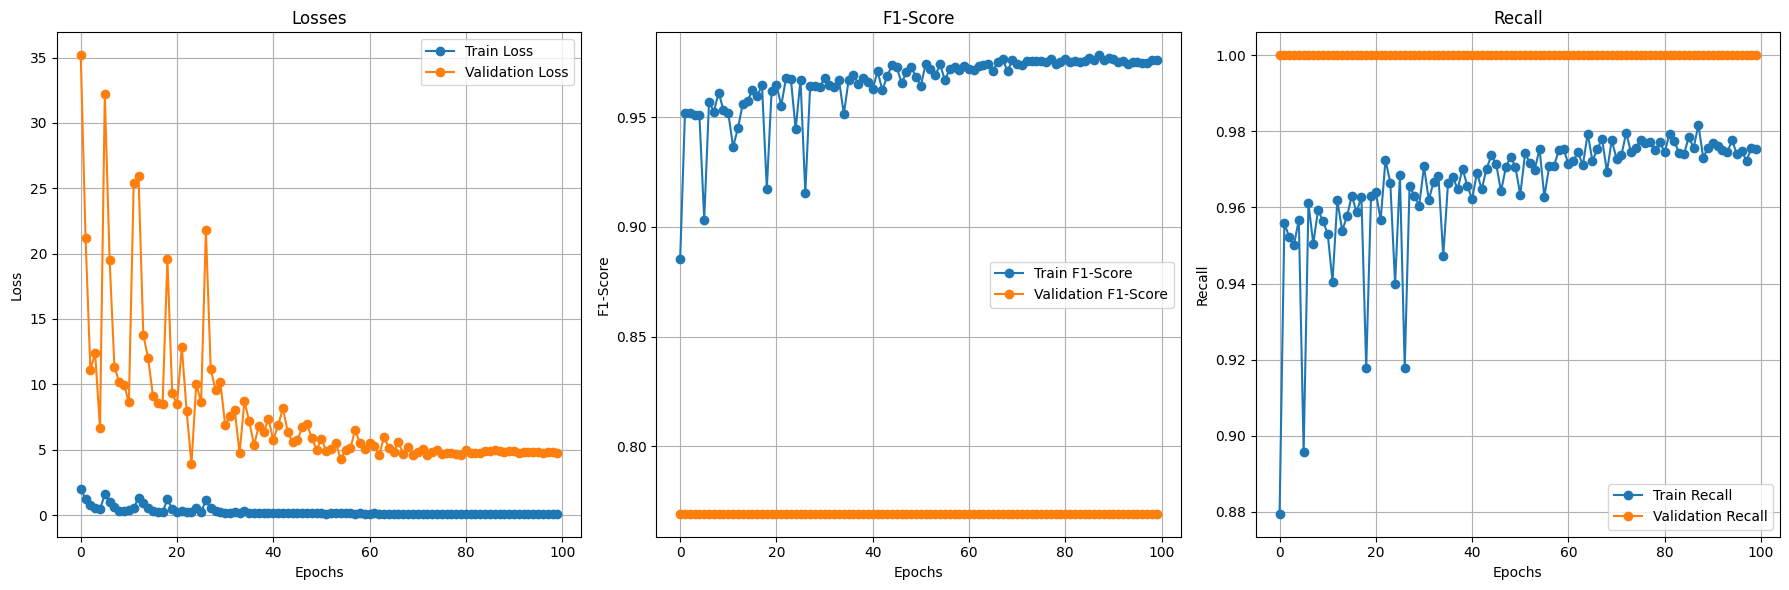

In [7]:
import matplotlib.pyplot as plt


plot_results(
    train_losses, 
    test_losses, 
    train_f1_scores, 
    test_f1_scores, 
    train_recalls, 
    test_recalls,
    f"./{args.saved_dir}/linear_{args.version}.png"
)


In [8]:
import pandas as pd

metrics_data = {
    "Epoch": list(range(1, len(train_losses) + 1)),
    "Train Loss": train_losses,
    "Validation Loss": test_losses,
    "Train F1-Score": train_f1_scores,
    "Validation F1-Score": test_f1_scores,
    "Train Recall": train_recalls,
    "Validation Recall": test_recalls,
}

metrics_df = pd.DataFrame(metrics_data)

metrics_csv_path = f"./{args.saved_dir}/metrics_{args.version}.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
